In [1]:
# @title Loading data

from google.colab import drive
drive.mount('/content/drive')

file_path = '/content/drive/My Drive/Colab Notebooks/lorenz_long_x.csv'

import pandas as pd
import numpy as np

org_data = pd.read_csv(file_path)
org_data = np.array(org_data)

# find missing values
nan_indices = np.where(np.isnan(org_data))

# delete missing values
org_data = np.delete(org_data, nan_indices)

# average and standard deviation
mean_value = np.mean(org_data)
std_dev = np.std(org_data)

# Standardization
org_data = (org_data - mean_value) / std_dev

Mounted at /content/drive


In [2]:
# @title Data segmentation

window_size = 1800
segments_model_selection    = 50

def overlapping_split(org_data, window_size,segments):

    org_data = np.asarray(org_data)
    step_size = 1

    segments = [
        org_data[i * step_size : i * step_size + window_size]
        for i in range(segments)
    ]

    return np.array(segments)

data = overlapping_split(org_data, window_size,segments_model_selection)
print(data.shape)

(50, 1800)


In [3]:
# @title Loading optuna and libraries

import matplotlib.pyplot as plt
import scipy.stats
import scipy.signal
import networkx as nx
import csv
import datetime

!pip install optuna
import optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.9/400.9 kB 8.8 MB/s eta 0:00:00


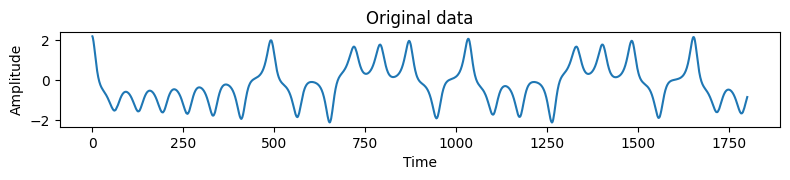

Data shape: (50, 1800)


In [4]:
# @title Visualization

plt.figure(figsize=(8, 3))
plt.subplot(2, 1, 1)
plt.plot(data[0,:])
plt.title('Original data')
plt.xlabel('Time')
plt.ylabel('Amplitude')


plt.tight_layout()
plt.show()

print('Data shape:',data.shape)

In [5]:
# @title Definition of Reservoir computing (without ``Class" setting!!)

####################
#input weight matrix
####################

def input_matrix(N_x,seed_value,input_scale,dim):

# Separate integer and decimal portions
    seed_int_low  = int(np.floor(seed_value))
    seed_int_high = int(np.ceil(seed_value))
    fraction      = seed_value - seed_int_low

# Random number generation for integer part
    np.random.seed(seed_int_low)
    random_matrix_low = np.random.uniform(-input_scale, input_scale, (N_x, dim))
    np.random.seed(seed_int_high)
    random_matrix_high = np.random.uniform(-input_scale, input_scale, (N_x, dim))

# Linear interpolation allows random seed values to correspond continuously to the matrix
    interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

    return interpolated_matrix

##############################
# Recurrent weight matrix
##############################

#Specify non-zero positions
def generate_random_binary_matrix(N_x, N_y, density, seed_value_binary):

    num_ones = int(N_x*N_y * density)
    matrix   = np.zeros(N_x*N_y, dtype=int)
    np.random.seed(seed_value_binary)
    ones_indices = np.random.choice(N_x*N_y, num_ones, replace=False)
    matrix[ones_indices] = 1

    return matrix.reshape((N_x, N_y))


def recurrent_matrix(N_x, density, rho,seed_value):

# Separate random seed value into integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

        random_binary_matrix_low   = generate_random_binary_matrix(N_x, N_x, density, seed_int_low)
        random_binary_matrix_high  = generate_random_binary_matrix(N_x, N_x, density, seed_int_high)
        interpolated_binary_matrix = \
         (1 - fraction) * random_binary_matrix_low + fraction * random_binary_matrix_high


# Separate integer and decimal portions
        seed_int_low  = int(np.floor(seed_value))
        seed_int_high = int(np.ceil(seed_value))
        fraction      = seed_value - seed_int_low

# Generate nonzero elements as random numbers following a uniform distribution
        rec_scale = 1.0

# Random number generation based on integer part
        np.random.seed(seed_int_low)
        random_matrix_low = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))
        np.random.seed(seed_int_high)
        random_matrix_high = np.random.uniform(-rec_scale, rec_scale, (N_x, N_x))

# Linear interpolation allows random seed values and matrices to correspond continuously
        interpolated_matrix = (1 - fraction) * random_matrix_low + fraction * random_matrix_high

        W = interpolated_binary_matrix * interpolated_matrix

        # Calculation of spectral radius
        eigv_list = np.linalg.eigh(W)[0]
        sp_radius = np.max(np.abs(eigv_list))

        # Scaling to a specified spectral radius rho
        W *= rho / sp_radius
        return W

########################

import numpy as np

def get_Wout_opt_batch(X_XT,D_XT,beta):

    Wout_opt = np.zeros((X_XT.shape[0], D_XT.shape[1], X_XT.shape[1]))

    for b in range(X_XT.shape[0]):
        Wout_opt[b] = (np.linalg.solve((X_XT[b] + beta * np.identity(X_XT.shape[1])).T, D_XT[b].T)).T

    return Wout_opt


###################
#Definition of batch learning (convexity)
###################

from numba import njit

@njit
def train_1d(train_U,train_D, x, T_train,Win,W,N_x,dim,alpha,discard_len,bias_scale):

    expanded_size = N_x + int(N_x * (N_x + 1) / 2)
    x = np.zeros(N_x)
    X_XT = np.zeros((expanded_size, expanded_size))
    D_XT = np.zeros((dim, expanded_size))

    X_XT_segments = np.zeros((train_U.shape[0]-T_train,expanded_size, expanded_size))
    D_XT_segments = np.zeros((train_U.shape[0]-T_train, dim, expanded_size))
    x_special_vec  = np.zeros((train_U.shape[0]-T_train, N_x))

    for n in range(train_U.shape[0]-1):
        # Reservoir update
        u = train_U[n,:]
        x_in = Win @ u
        x = (1 - alpha) * x + alpha * np.tanh(W @ x + x_in + bias_scale)

        d = train_D[n,:]

        if n > discard_len:

            #######################
            # excellent Ohkubo-Inubushi method

            # Obtain indices of the upper triangle (i<=j)
            i, j = np.triu_indices(N_x)

            #Generate quadratic terms for all samples at once -> shape (n_samples, n_pairs)
            s = x[i] * x[j]

            # Join along the column axis (axis=1) -> shape (n_samples, n_features + n_pairs)
            x_quad = np.concatenate((x, s))
            #######################

            X_XT += np.outer(x_quad,  x_quad)
            D_XT += np.outer(d,  x_quad)

        if n >= T_train-1:
            X_XT_segments[n-T_train+1,:,:] = X_XT
            D_XT_segments[n-T_train+1,:,:] = D_XT
            x_special_vec[n-T_train+1,:]   = x

    return X_XT_segments, D_XT_segments, x_special_vec


########################
#induction formula for creating estimated data
########################

#excellent Ohkubo-Inubushi method

def quadratic_expand(x):
    x = np.asarray(x)
    if x.ndim == 1:
        x = x.reshape(1, -1)   # 1 sample case
    n_samples, n_features = x.shape

    # Obtain indices of the upper triangle (i<=j)
    i, j = np.triu_indices(n_features)

    #Generate quadratic terms for all samples at once -> shape (n_samples, n_pairs)
    s = x[:, i] * x[:, j]

    # Join along the column axis (axis=1) -> shape (n_samples, n_features + n_pairs)
    x_quad = np.concatenate((x, s), axis=1)
    return x_quad

def run_batch(test_U, x_special_vec, Win, W, Wout, alpha, T_test, bias_scale):
    M, Nu = test_U.shape
    Nx = x_special_vec.shape[1]
    Ny = Wout.shape[1]

    Y_pred = np.zeros((M, Ny, T_test))

    # initialization

    x = x_special_vec.copy()  # shape (M, Nx)
    y = test_U.copy()         # shape (M, Nu)

    for n in range(T_test):

        x_in = y @ Win.T        # shape (M, Nx)
        Wx = x @ W.T            # shape (M, Nx)

        x = (1 - alpha) * x + alpha * np.tanh(Wx + x_in + bias_scale)

        # Wout[m,:,:] @ x[m,:]
        x_quad = quadratic_expand(x)  # shape (M, Nx + N_x * (N_x + 1) / 2)
        y_pred = np.matmul(Wout, x_quad[..., None])[..., 0]

        Y_pred[:, :, n] = y_pred
        y = y_pred

    return Y_pred

In [6]:
# @title Definition of implementation of train and test

def impl_train_test(T_train,impl_set,dim,N_x,seed_value,input_scale,density, \
                    rho,T_0,lag,alpha,discard_len,bias_scale,beta,T_test):


    data_delay_train = np.zeros((T_train+impl_set.shape[0]+1,dim), dtype=float)

    #Fix input and recurrent weight matrices

    Win= input_matrix(N_x,seed_value,input_scale,dim)
    W = recurrent_matrix(N_x, density, rho,seed_value)

    ##########################################
    #Convert training data to a delay coordinate system

    for i in range(dim):

        data_delay_train[:,i] = org_data[T_0-T_train-i*lag:T_0+impl_set.shape[0]-i*lag+1] # i*lag Step-delayed time series


    # Initialization of training data

    train_U = np.zeros((T_train+impl_set.shape[0],dim), dtype=float)
    train_D = np.zeros((T_train+impl_set.shape[0],dim), dtype=float)

    #Input/output of training data

    train_U = data_delay_train[:T_train+impl_set.shape[0],:]
    train_D = data_delay_train[1:T_train+impl_set.shape[0]+1,:]

    ##The last time data of the training data output must overlap with the test data,
    ##since non-increment online learning!

    #Ridge
    X_XT_segments = np.zeros((impl_set.shape[0],N_x, N_x))
    D_XT_segments = np.zeros((impl_set.shape[0],dim, N_x))
    x_special_vec = np.zeros((impl_set.shape[0],N_x))

    X_XT_segments, D_XT_segments,x_special_vec = train_1d(train_U,train_D,np.zeros(N_x),T_train, \
                                  Win, W, N_x, dim, alpha,discard_len,bias_scale)

    # Generate regression weight matrix

    Wout= None
    Wout= get_Wout_opt_batch(X_XT_segments, D_XT_segments,beta)



    #######################
    # Model selection phase
    test_Y           = np.zeros((impl_set.shape[0],dim,T_test))
    test_D           = np.zeros((impl_set.shape[0],dim,T_test))
    data_delay_test         = np.zeros((impl_set.shape[0],dim,T_test+1), dtype=float)
    tentative_test_Y        = np.zeros((T_test,dim))


##############################
#test in model selection phase

    for i in range(dim):

        data_delay_test[:,i,:] = impl_set[:,T_0-i*lag:
                                        T_0+T_test-i*lag+1] # i*lag step delayed time series


#Generate estimated data


        test_Y[:,:,:] = run_batch(data_delay_test[:,:,0],x_special_vec[:,:], \
                                      Win,W,Wout[:,:],alpha,T_test,bias_scale)
        test_D[:,:,:] = data_delay_test[:,:,1:T_test+1]

    return np.abs(test_Y[:,0,T_test-1]-test_D[:,0,T_test-1]), test_Y, test_D


In [7]:
# @title Setting of Optuna study

study_without_save = optuna.create_study(direction="minimize")

storage = "sqlite:////content/drive/My Drive/Colab Notebooks/1dim_reservoir_quadoutput_trials.db"
study_with_save = optuna.create_study(study_name="1dim_Reservoir_QuadOutput",direction="minimize",storage=storage,load_if_exists=True)

[I 2025-10-15 11:41:37,885] A new study created in memory with name: no-name-b4fa0314-46d1-4762-bf07-167dc8b010b4
[I 2025-10-15 11:41:42,575] Using an existing study with name '1dim_Reservoir_QuadOutput' instead of creating a new one.


In [8]:
# @title Hyperparameters

T_train                = 1500  # Training period
T_test                 = 100   # Forecast period (in the model selection phase)
T_test_general_perform = 100   # Forecast period for generalizaiton performance (model evaluation phase)

discard_len  = 10    # Number of steps not learned at the beginning (not important)

max_lag    = 5    # Maximum of lag for delay coordinate
max_dim    = 10    # Maximum of dimension for delay coordinate

initial_time = 0
#####################################################
#Hyperparameters: Bayesian optimization for Reservoir

Node      = 28   # Reservoir Node
n_trials  = 50   # Number of times to test with optuna (generate MAE for this number of times)

study = study_without_save # choose ``study_without_save" or ``study_with_save""

In [9]:
# @title Implement set

impl_set = data[:,initial_time:initial_time+T_train+max_lag*max_dim+2*T_test]

print("data length from initial_time:",data[:,initial_time:].shape[1])
print("shape of implement set",impl_set.shape)

data length from initial_time: 1800
shape of implement set (50, 1750)


In [10]:
# @title Implementation of Bayesian optimization of Reservoir

%%time

def objective(trial):
    lag         = trial.suggest_int("lag", 3, max_lag)
    dim         = trial.suggest_int("dim", 3, max_dim)
    N_x         = trial.suggest_int("N_x", Node, Node)                #fixed here
    beta        = trial.suggest_float("beta", 0.0001, 0.0001)
    density     = trial.suggest_float("density", 0.01, 1)
    input_scale = trial.suggest_float("input_scale", 0, 1.5)
    rho         = trial.suggest_float("rho", 0, 1.5)
    alpha       = trial.suggest_float("alpha", 0, 1)
    seed_value  = trial.suggest_float("seed_value", 0, 100)
    bias_scale  = trial.suggest_float("bias_scale", -1.5, 1.5)

    #Test start time (model selection phase)

    T_0 = T_train + lag * (dim-1)

    #Implementation of train-test

    mae,_,_ = impl_train_test(T_train,impl_set,dim,N_x,seed_value,input_scale,density, \
                    rho,T_0,lag,alpha,discard_len,bias_scale,beta,T_test)

    return np.mean(mae)

######################
# Perform optimization

study.optimize(objective, n_trials)

# Display of optimization results
print("Best trial:")
trial = study.best_trial
print(f"  'params': {trial.params},")
print(f"  'value': {trial.value},")

[I 2025-10-15 11:41:59,279] Trial 0 finished with value: 0.7736448924927035 and parameters: {'lag': 4, 'dim': 6, 'N_x': 28, 'beta': 0.0001, 'density': 0.5418908897420527, 'input_scale': 0.15257227959285363, 'rho': 1.250277413260212, 'alpha': 0.6836272493236724, 'seed_value': 67.867085306932, 'bias_scale': 0.46079983367371247}. Best is trial 0 with value: 0.7736448924927035.
[I 2025-10-15 11:42:00,532] Trial 1 finished with value: 0.19031827661004613 and parameters: {'lag': 5, 'dim': 8, 'N_x': 28, 'beta': 0.0001, 'density': 0.39681202759228534, 'input_scale': 0.7915613813264127, 'rho': 0.36257333347311654, 'alpha': 0.18043346229870472, 'seed_value': 58.352662895574255, 'bias_scale': 0.48936600347696624}. Best is trial 1 with value: 0.19031827661004613.
[I 2025-10-15 11:42:01,865] Trial 2 finished with value: 0.179369799573624 and parameters: {'lag': 5, 'dim': 10, 'N_x': 28, 'beta': 0.0001, 'density': 0.05402924183568642, 'input_scale': 0.3170506355208958, 'rho': 0.8632232684471561, 'alp

Best trial:
  'params': {'lag': 5, 'dim': 9, 'N_x': 28, 'beta': 0.0001, 'density': 0.08741926880077117, 'input_scale': 0.732378618471146, 'rho': 0.8420131111088087, 'alpha': 0.11030299437835824, 'seed_value': 56.313599312687444, 'bias_scale': 0.5920037727739922},
  'value': 0.029116784940141735,
CPU times: user 1min 16s, sys: 2.51 s, total: 1min 19s
Wall time: 1min 26s


In [11]:
# @title Best hyperparameters

best_params = study.best_params

lag          = best_params["lag"]
dim          = best_params["dim"]
N_x          = best_params["N_x"]
beta         = best_params["beta"]
density      = best_params["density"]
input_scale  = best_params["input_scale"]
rho          = best_params["rho"]
alpha        = best_params["alpha"]
seed_value   = best_params["seed_value"]
bias_scale   = best_params["bias_scale"]

print(f"max_lag= {max_lag}")
print(f"max_dim= {max_dim}")
print(f"lag= {lag}")
print(f"dim= {dim}")
print(f"N_x= {N_x}")
print(f"beta= {beta}")
print(f"density= {density}")
print(f"input_scale= {input_scale}")
print(f"rho= {rho}")
print(f"alpha= {alpha}")
print(f"seed_value= {seed_value}")
print(f"bias_scale= {bias_scale}")

max_lag= 5
max_dim= 10
lag= 5
dim= 9
N_x= 28
beta= 0.0001
density= 0.08741926880077117
input_scale= 0.732378618471146
rho= 0.8420131111088087
alpha= 0.11030299437835824
seed_value= 56.313599312687444
bias_scale= 0.5920037727739922


In [12]:
# @title Data Segmentation Again

window_size = 1800
segments = 3000

data = overlapping_split(org_data, window_size,segments)
impl_set = data[:,initial_time:initial_time+T_train+max_lag*max_dim+T_test + \
                segments_model_selection + T_test_general_perform]

print("data length from initial_time:",data[:,initial_time:].shape[1])
print("shape of implement set",impl_set.shape)

data length from initial_time: 1800
shape of implement set (3000, 1800)


In [13]:
# @title Training in Model Evaluation phease

%%time

#Test start time (model evaluation phase)
#NOT T_0 = T_train+lag*(dim-1)!!

T_0 = T_train+lag*(dim-1)+T_test + segments_model_selection

mae,test_Y,test_D = impl_train_test(T_train,impl_set,dim,N_x,seed_value,input_scale,density, \
                    rho,T_0,lag,alpha,discard_len,bias_scale,beta,T_test_general_perform)

mae_mean = np.mean(mae)

CPU times: user 1min 12s, sys: 3.4 s, total: 1min 15s
Wall time: 55.5 s


In [ ]:
# @title Implementation of Model Evaluation

%%time

#print("MAE:", mae)
print("MAE mean:", mae_mean)
print("forecast period for general-perform:", T_test_general_perform)

fig = plt.figure(figsize=(8,3), dpi=100)
plt.rcParams["font.size"] = 15
plt.grid(which='major', linestyle='--', axis='both')
plt.xlabel("Lag")
plt.ylabel("Amplitude")
plt.plot(test_Y[:,0,T_test-1], color="black", label=f"pred for {test_Y.shape[0]} times")
plt.plot(test_D[:,0,T_test-1], color = "red",label=f"data for {test_D.shape[0]} times")
plt.legend()#loc='lower right')
plt.tight_layout()
plt.show()


fix_test_num = 3

# Running Test Predictions
plt.figure(figsize=(8, 4))
plt.plot(test_Y[fix_test_num,0,:], color = "black",label=f"specific pred No.{fix_test_num}")
plt.plot(test_D[fix_test_num,0,:], color = "red",label=f"specific original-data No.{fix_test_num}")
plt.legend()#loc='lower right')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.grid(which='major', linestyle='--', axis='both')

plt.show()

MAE mean: 0.020464444147215557
forecast period for general-perform: 100
